In [109]:
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer
from tqdm import tqdm_notebook as tqdm
import regex as re
from sklearn.model_selection import train_test_split
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
import nltk
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from sklearn.feature_extraction import DictVectorizer
import itertools
from sklearn.naive_bayes import BernoulliNB
from sklearn.naive_bayes import GaussianNB
import pdb
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.decomposition import PCA

In [2]:
def cleanup(data_df):
    
    
    
    # remove urls
    data_df['regtext'] = data_df['text'].apply(lambda t: re.sub(r"http.?://[^\s]+[\s]?", '', t))
    
    # remove special characters
    data_df['regtext'] = data_df['regtext'].apply(lambda t: re.sub(r"[^a-zA-Z0-9]+", ' ', t))

    # remove numbers
    data_df['regtext'] = data_df['regtext'].apply(lambda t: re.sub(r"\s?[0-9]+\.?[0-9]*", '', t))
    
    # make lowercase
    data_df['regtext'] = data_df['regtext'].str.lower()

In [3]:
def tokenStem(data_df):
    
    stemmer = nltk.PorterStemmer()
    tokenizer = nltk.word_tokenize
    stop_words = set(stopwords.words('english'))

    
    #tokenize
    data_df['regtext'] = data_df['regtext'].apply(lambda t: tokenizer(t))
    
    #stem
    data_df['regtext'] = data_df['regtext'].apply(lambda t: [stemmer.stem(word) for word in t if word not in stop_words])

In [4]:
def genExtrafeatures(data_df):    
    
    def count_occurences(character, word_array):
        counter = 0
        for j, word in enumerate(word_array):
            for char in word:
                if char == character:
                    counter += 1
        return counter
    
    # split text
    data_df['split'] = data_df['text'].apply(lambda t: t.split(" "))
    
    # number of characters
    data_df['nbr_chars'] = data_df['text'].apply(lambda t: len(t))
    
    # number of words in tweet
    data_df['nbr_words'] = data_df['split'].apply(lambda t: len(t))
    
    # number of tokens
    data_df['nbr_tokens'] = data_df['regtext'].apply(lambda t: len(t))
    
    # tok - words
    data_df['wordlesstok'] = data_df['nbr_words'] - data_df['nbr_tokens']
    
    # number of hashtags
    data_df['nbr_tags'] = data_df['split'].apply(lambda t: count_occurences('#', t))
    
    # number of !
    data_df['nbr_ex'] = data_df['split'].apply(lambda t: count_occurences('!', t))
    
    # number of ?
    data_df['nbr_q'] = data_df['split'].apply(lambda t: count_occurences('', t))
    
    # number of mentions
    data_df['nbr_mentions'] = data_df['split'].apply(lambda t: count_occurences('@', t))
    
    # number of urls
    data_df['has_url'] = data_df['text'].str.contains('http')
    


In [5]:
## Load Data

path = 'Data/Cleaned/xrp_cleaned_date.pkl'
randata_df = pd.read_pickle(path)

path = 'Data/Raw/goodUserCrypto.pkl'
gooddata_df = pd.read_pickle(path)

cleanup(gooddata_df)
cleanup(randata_df)
tokenStem(gooddata_df)
tokenStem(randata_df)
genExtrafeatures(gooddata_df)
genExtrafeatures(randata_df)

In [6]:
## Create Spam List

spamWords = ['ico', 'freetoken', 'token', 'airdrop', 'airdrops', 'rippleprice_', 'bigpumpgroup', 'bounty', 'usd', 'korea price', 'binance', 'current price', \
            'cryptopricexrp', 'cryptobot', 'coinstats', 'coinpricenow', 'cryptogulp', 'ripplebot1h', 'bigdata', 'RippleMarket','CryptoGulp', 'ripplebot_cs', \
            'cryptopricebot','VirtualMoneyBot','coinstats','JustFactsNL', 'free', 'trx', 'XrpTicker', 'aWebAnalysis', 'scotlarock727', '1bitcoinkaclira', \
            'pureinvestments']
spamWordsCon = ("|").join(spamWords)

## Label Spam
randata_df['Spam'] = randata_df['text'].str.contains(spamWordsCon)
gooddata_df['Spam'] = False

In [7]:
## figure out how to remove users?

In [8]:
## Make training list



training_df = gooddata_df
training_df = training_df.append(randata_df[randata_df['Spam'] == True])

In [9]:
training_df.head()

,ID,Spam,datetime,has_media,has_url,is_reply,is_retweet,medias,nbr_chars,nbr_ex,...,nbr_tokens,nbr_words,regtext,rounded_dateTime,split,text,url,user_id,usernameTweet,wordlesstok
0,8.794407e+17,False,2017-06-26 16:46:13,NaN,False,1.0,0.0,NaN,135,0,...,10,27,"[lost, one, nick, think, term, creation, troub...",NaT,"[Lost, me, on, that, one,, Nick, , \nThink, it...","Lost me on that one, Nick \nThink it's the te...",/PJSanderson/status/879440684624871424,168649848,PJSanderson,17
1,9.830839e+17,False,2018-04-08 16:47:12,NaN,False,1.0,0.0,NaN,202,0,...,12,34,"[freedom, speech, protect, infring, govern, in...",NaT,"[Not, only, that,, but, freedom, of, speech, i...","Not only that, but freedom of speech is only p...",/SeamusWalsh2/status/983083861763473408,343861762,SeamusWalsh2,22
2,9.895482e+17,False,2018-04-26 12:54:16,1.0,True,0.0,0.0,[https://t.co/ra4K4ln6yx],184,0,...,19,27,"[fantast, video, archiv, coinscrum, minicon, w...",NaT,"[A, Fantastic, Video, , From, , The, Archives,...",A Fantastic Video From The Archives - Coinsc...,/coinscrum/status/989548224171167744,1196956998,coinscrum,8
3,9.626423e+17,False,2018-02-11 05:59:37,NaN,True,0.0,0.0,NaN,330,0,...,28,54,"[everi, morn, read, post, elit, trader, list, ...",NaT,"[Every, morning, I, read, through, the, posts,...",Every morning I read through the posts from ...,/whatbitcoindid/status/962642274596335616,893818632089763840,whatbitcoindid,26
4,9.915655e+17,False,2018-05-02 02:30:13,NaN,False,0.0,0.0,NaN,217,0,...,19,38,"[ask, idl, suffer, eat, sand, crow, vultur, ho...",NaT,"[""Ask, them, why, they, idle, there\nWhile, we...","""Ask them why they idle there\nWhile we suffer...",/poetrypotion/status/991565507051577344,62152913,poetrypotion,19


In [10]:
training_df['has_media'].fillna(0, inplace=True)

In [24]:
def reg2dict(row):
    out = {}
    
    for w in row['regtext']:
        out[w] = 1
        
    out['has_media'] = row['has_media']
    out['has_url'] = row['has_url']
    out['is_reply'] = row['is_reply']
    out['wordlesstok'] = row['wordlesstok']
    out['is_retweet'] = row['is_retweet']
    out['nbr_chars'] = row['nbr_chars']
    out['nbr_ex'] = row['nbr_ex']
    out['nbr_favorite'] = row['nbr_favorite']
    out['nbr_mentions'] = row['nbr_mentions']
    out['nbr_q'] = row['nbr_q']
    out['nbr_reply'] = row['nbr_reply']
    out['nbr_retweet'] = row['nbr_retweet']
    out['nbr_tags'] = row['nbr_tags']
    out['nbr_tokens'] = row['nbr_tokens']
    out['nbr_words'] = row['nbr_words']    
    
    return out

In [17]:
a = training_df.iloc[0]
b = reg2dict(a)
b

{'creation': 1,
 'divert': 1,
 'elsewher': 1,
 'has_media': 0.0,
 'has_url': False,
 'is_reply': 1.0,
 'is_retweet': 0.0,
 'lost': 1,
 'nbr_chars': 135,
 'nbr_ex': 0,
 'nbr_favorite': 0.0,
 'nbr_mentions': 0,
 'nbr_q': 0,
 'nbr_reply': 1.0,
 'nbr_retweet': 0.0,
 'nbr_tags': 0,
 'nbr_tokens': 10,
 'nbr_words': 27,
 'nick': 1,
 'one': 1,
 'term': 1,
 'think': 1,
 'troubl': 1,
 'valu': 1,
 'wordlesstok': 17}

In [36]:
X_data = []

for index, row in training_df.iterrows():
    X_data.append(reg2dict(row))

In [38]:
## dictVectorize

vec = DictVectorizer()

X_data_v = vec.fit_transform(X_data).toarray()

In [40]:
Y_data = training_df['Spam'].tolist()

In [90]:
X_train, X_test, Y_train, Y_test = train_test_split(X_data_v, Y_data, test_size = 0.2)

In [66]:
clf = BernoulliNB()
clf.fit(X_train, Y_train)

BernoulliNB(alpha=1.0, binarize=0.0, class_prior=None, fit_prior=True)

fig = plt.figure()

labels = ['Spam', 'Not Spam']
i = 0
for v in [True, False]:
    subset = plot_df[plot_df['Pred'] == v]
    sns.distplot(subset['Pval'], label = str(v))
    i += 1
    
plt.legend()
fig.savefig('ExpandedFeatureSpamClassifier')

In [76]:
Y_pred = clf.predict(X_test)
Pval = clf.predict_log_proba(X_test)

In [61]:
Y_pred

array([False, False, False, ...,  True,  True,  True], dtype=bool)

In [77]:
Pval[Y_pred == True][:, 0]

array([ -94.62673231,  -95.24180458, -150.07100429, ...,  -27.0825813 ,
        -14.16363335, -122.9154811 ])

In [47]:
subset = Y_pred[Y_pred == True]
subset

array([ True,  True,  True, ...,  True,  True,  True], dtype=bool)

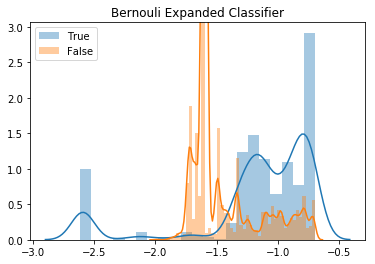

In [197]:
fig = plt.figure()

labels = ['Spam', 'Not Spam']
i = 0
for v in [True, False]:
    sns.distplot(Pval[Y_pred == v][:, i], label = str(v))
    i += 1
    
plt.legend()
plt.title('Bernouli Expanded Classifier')
fig.savefig('BernouliClassifier')

In [84]:
#RFC = RandomForestClassifier()
# parameters = {'n_estimators': [5, 10, 20, 50], 'max_depth': [50, 100, 300, 500], 'min_samples_leaf': [100, 250, 500]}
# gridSearch = GridSearchCV(RFC, param_grid=parameters, n_jobs=-1, verbose=1)

In [85]:
# gridSearch.fit(X_train, Y_train)
# print(gridSearch.best_params_)
# topClf = gridSearch.best_estimator_

Fitting 3 folds for each of 48 candidates, totalling 144 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed: 17.0min
C:\Users\Sam\Anaconda3\lib\site-packages\sklearn\externals\joblib\pool.py:438: UserWarning: Failed to clean temporary folder: C:\Users\Sam\AppData\Local\Temp\joblib_memmaping_pool_15064_2773730393224
  warnings.warn("Failed to clean temporary folder: %s" % folder_path)


KeyboardInterrupt: 

In [190]:
RFC = RandomForestClassifier(max_depth=7)
RFC.fit(X_train, Y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=7, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [193]:
Y_pred = RFC.predict(X_test)
Pval = RFC.predict_log_proba(X_test)

In [179]:
Pval

array([[ 1.,  0.],
       [ 0.,  1.],
       [ 1.,  0.],
       ..., 
       [ 1.,  0.],
       [ 0.,  1.],
       [ 1.,  0.]])

In [174]:
Pval[np.isinf(Pval[:, 0]), 0] = np.log(.00001)
Pval[np.isinf(Pval[:, 0]), ] = np.log(.00001)

In [175]:
Pval[1, 0]

-inf

In [165]:
Pval

array([[ -9.65964690e-03,  -4.64462412e+00],
       [  1.00000000e+00,   0.00000000e+00],
       [ -2.24985961e-01,  -1.60210203e+00],
       ..., 
       [ -8.20969517e-03,  -4.80654153e+00],
       [  1.00000000e+00,   0.00000000e+00],
       [ -5.11026925e-03,  -5.27905723e+00]])

In [166]:
np.isinf(Pval[1, 0])

False

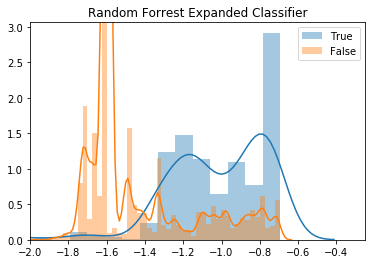

In [198]:
fig = plt.figure()

labels = ['Spam', 'Not Spam']
i = 0
for v in [True, False]:
    sns.distplot(Pval[Y_pred == v][:, i], label = str(v))
    i += 1
    
plt.legend()
plt.title('Random Forrest Expanded Classifier')
plt.xlim([-2, -0.25])
fig.savefig('RFClassifierLog')